# Wstęp do sieci neuronowych


<img src="figures/L9/cat_neuron.jpg" width=500>

Ref: 

* http://cs231n.github.io/optimization-1/ 

* https://github.com/leriomaggio/deep-learning-keras-tensorflow/blob/master/1.3%20Introduction%20-%20Keras.ipynb

* http://colah.github.io/posts/2014-10-Visualizing-MNIST/

* https://github.com/peterroelants/peterroelants.github.io/blob/master/notebooks/neural_net_implementation/neural_network_implementation_part02.ipynb


Na dzisiejszych zajęciach omówimy jak można zaimplementować jako sieć neuronową znany nam model regresji logistycznej, najpierw bardziej ręcznie, a następnie z użyciem pakietu keras. Omówimy na końcu spojrzenie na sieci neuronowe z perspektywy uczenia reprezentacji.

# Setup

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.decomposition import RandomizedPCA
from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle
import matplotlib.pyplot as plt 
from matplotlib.colors import colorConverter, ListedColormap
from matplotlib import cm #
import os
import tqdm
os.environ['KERAS_BACKEND'] = 'theano'
import keras
from keras.datasets import mnist
from sklearn.datasets import load_iris
from sklearn.cross_validation import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD, Adam
%matplotlib inline
np.random.seed(seed=1)

In [44]:
# Small MNIST 
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
sm_train = mnist_x_train[0:500].astype('float32') / 255.
sm_y_train = mnist_y_train[0:500]
sm_test = mnist_x_test[0:500].astype('float32') / 255.
sm_y_test = mnist_y_test[0:500]
sm_train = sm_train.reshape((len(sm_train), np.prod(sm_train.shape[1:])))
sm_test = sm_test.reshape((len(sm_test), np.prod(sm_test.shape[1:])))
print sm_train.shape
print sm_test.shape

(500, 784)
(500, 784)


In [45]:
if not keras.__version__[0] == '2':
    raise Exception("Prosze zainstalowac keras>=2.0.0")

In [46]:
def logistic(z): 
    return 1 / (1 + np.exp(-z))

def nn(x, w): 
    return logistic(x.dot(w.T))

def nn_predict(x,w): 
    return np.array(np.around(nn(x,w)))

def cost(y, t):
    return - np.sum(np.multiply(t, np.log(y)) + np.multiply((1-t), np.log(1-y)))

In [47]:
# Define and generate the samples
nb_of_samples_per_class = 100  # The number of sample in each class
red_mean = [-1,0]  # The mean of the red class
blue_mean = [1,0]  # The mean of the blue class
std_dev = 1.2  # standard deviation of both classes
# Generate samples from both classes
x_red = np.random.randn(nb_of_samples_per_class, 2) * std_dev + red_mean
x_blue = np.random.randn(nb_of_samples_per_class, 2) * std_dev + blue_mean

# Merge samples in set of input variables x, and corresponding set of output variables t
X_toy = np.vstack((x_red, x_blue))
t_toy = np.vstack((np.zeros((nb_of_samples_per_class,1)), np.ones((nb_of_samples_per_class,1))))

toy_train, toy_test, toy_y_train, toy_y_test = train_test_split(X_toy, t_toy, test_size=0.15)

# Przyda sie do sekcji o kerasie
toy_y_train_one_hot = keras.utils.to_categorical(toy_y_train)
toy_y_test_one_hot = keras.utils.to_categorical(toy_y_test)

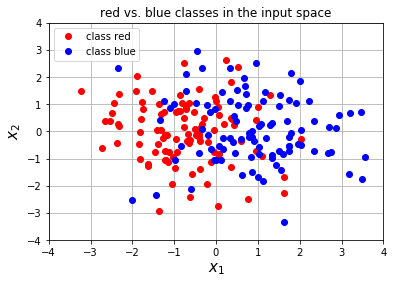

In [48]:
# Plot both classes on the x1, x2 plane
plt.plot(x_red[:,0], x_red[:,1], 'ro', label='class red')
plt.plot(x_blue[:,0], x_blue[:,1], 'bo', label='class blue')
plt.grid()
plt.legend(loc=2)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.axis([-4, 4, -4, 4])
plt.title('red vs. blue classes in the input space')
plt.show()

# Siec Neuronowa, a regresja logistyczna

Przypomnijmy sobie co robi regresja logistyczna. Z L7:

Przekształcając $$ \log(o) = \sum \theta_i x_i $$ otrzymujemy *bezpośrednio*, że $$ p(y | x) = \mbox{sigmoid}(\sum \theta_i x_i) $$, gdzie $sigmoid(a) = \frac{1}{1 + \exp(-a)}$.

Można ostatni wzór zapisać w postaci "sieci neuronowej":

<center><img width=500 src="figures/L9/logreg.png"></center>

To co pozostaje to jak wyznaczyć wagi przez optymalizacją. Przypomnijmy, że szukamy parametrów optymalizujących log-likelihood $$ LL(\hat y, y) = CE(\hat y, y) = \sum_{i=1}^{N} y \log\hat(y) $$. W regresji liniowej było prosto!

[Opisać/wyjaśnic cross entropy]

## Czego szuka regresja logistyczna

Regresja logistyczna dostaje kare za najdrobniejsza pomyłkę. Jeśli dla kasy 1 mówi z pewnością 99%, to dalej będzie niezerowy koszt:
    
<img width=500 src="figures/L9/logreg_vs_svm.png">

## Optymalizacja

Jak dotad nie rozpatrywaliśmy optymalizacji. Regresja liniowa ma rozwiązanie "zamknięte", ale nie wiemy jak optymalizować błąd regresji logistycznej!

$$ \theta^* = argmax_{\theta} L(p( \hat y | x, \theta), y) = CE(p(\hat y | x, \theta), y) = \sum_{i=1}^{N} y \log\hat(y) $$.

Dla klas binarnych:

$$ \sum_{i=1}^N y_i \log \hat y_i - (1 - y_i) \log (1 - \hat y_i ) $$

Jak znaleźć $\theta^*$? Użyjemy metody gradientowej:

$$ \theta^{t+1} = \theta^{t} - \alpha \frac{\partial L}{\partial \theta} $$

### Funkcja kosztu nie jest już taka prosta!

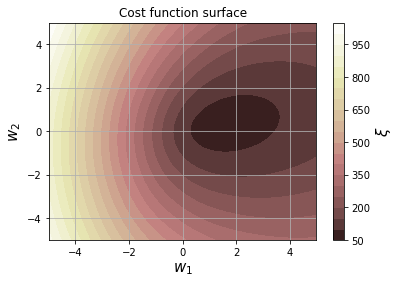

In [49]:
# Plot the cost in function of the weights
# Define a vector of weights for which we want to plot the cost
nb_of_ws = 100 # compute the cost nb_of_ws times in each dimension
ws1 = np.linspace(-5, 5, num=nb_of_ws) # weight 1
ws2 = np.linspace(-5, 5, num=nb_of_ws) # weight 2
ws_x, ws_y = np.meshgrid(ws1, ws2) # generate grid
cost_ws = np.zeros((nb_of_ws, nb_of_ws)) # initialize cost matrix

# Fill the cost matrix for each combination of weights
for i in range(nb_of_ws):
    for j in range(nb_of_ws):
        cost_ws[i,j] = cost(nn(toy_train, np.asmatrix([ws_x[i,j], ws_y[i,j]])) , toy_y_train)
        
# Plot the cost function surface
plt.contourf(ws_x, ws_y, cost_ws, 20, cmap=cm.pink)
cbar = plt.colorbar()
cbar.ax.set_ylabel('$\\xi$', fontsize=15)
plt.xlabel('$w_1$', fontsize=15)
plt.ylabel('$w_2$', fontsize=15)
plt.title('Cost function surface')
plt.grid()
plt.show()

### Implementacja SGD

[Wyprowadzić na tablicy wzór na dLL/dtheta_i, jak to sie ma do backprop]

Jak właśnie pokazaliśmy $$ \frac{\partial L}{\partial \theta_i} = x_i (\hat y_i - t_i) $$

[Interpretacja geometryczna gradientu regresji logistycznej]

### Zadanie 1, Nauka regresji logistycznej przez GD [2pkt]

(Uwaga: jest GD nie SGD ponieważ liczymy gradient na całym zbiorze)

1. Zaimplementuj GD dla zbioru danych toy. 
2. Wygeneruj wizualizacje procesu uczenia (ostatnia komórka)
3. Narysuj wizualizacje dla learning_rate=10.0, 5.0, 2.5, 1.0
4. Dla jakiego learning_rate osiągamy najlepszą dokladnosc na (toy_test, toy_y_test)?

Co powinno wyjść dla odpowiednio 5.0 oraz 2.5

<img width=200 src="figures/L9/lr5.png">
<img width=200 src="figures/L9/lr2.5.png">

Uwaga: Należy uśredniać gradient w funkcji "gradient", dziękujemy za zauważenie błędu Krzysztofowi Paskowi.

In [125]:
def gradient(w, x, t):
    f = np.vectorize(lambda x: 1/float(1+np.exp(-x)))
    a = f(x.dot(w.T)) - t
    r=[1,1]
    r[0] = np.multiply(x[:,0], a).mean()
    r[1] = np.multiply(x[:,1], a).mean()
    return np.array(r)
def delta_w(w_k, x, t, learning_rate):
    grad = gradient(w_k, x, t)
    print grad * learning_rate
    return grad * learning_rate
        

# Parametry uczenia 
w = np.asmatrix([-4, -2])
learning_rate = 2.5

# Uczenie
nb_of_iterations = 10
w_iter = [w] 
for i in range(nb_of_iterations):
    dw = delta_w(w, toy_train, toy_y_train, learning_rate) 
    w = w - dw 
    w_iter.append(w)

[ 0.00808474 -0.0017665 ]
[ 0.00807906 -0.00176525]
[ 0.00807342 -0.00176402]
[ 0.00806785 -0.0017628 ]
[ 0.00806233 -0.0017616 ]
[ 0.00805686 -0.0017604 ]
[ 0.00805146 -0.00175922]
[ 0.00804613 -0.00175806]
[ 0.00804085 -0.0017569 ]
[ 0.00803564 -0.00175577]


[matrix([[-4, -2]]), matrix([[-4.00808474, -1.9982335 ]]), matrix([[-4.0161638 , -1.99646825]]), matrix([[-4.02423722, -1.99470423]]), matrix([[-4.03230507, -1.99294143]]), matrix([[-4.0403674 , -1.99117983]]), matrix([[-4.04842426, -1.98941943]]), matrix([[-4.05647572, -1.9876602 ]]), matrix([[-4.06452185, -1.98590215]]), matrix([[-4.0725627 , -1.98414524]]), matrix([[-4.08059834, -1.98238948]])]


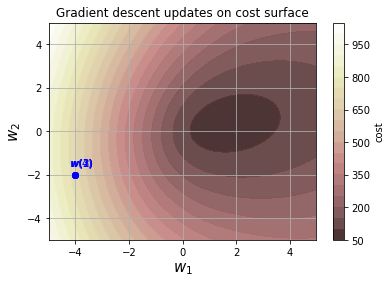

In [126]:
# Plot the first weight updates on the error surface
# Plot the error surface
plt.contourf(ws_x, ws_y, cost_ws, 20, alpha=0.9, cmap=cm.pink)
cbar = plt.colorbar()
cbar.ax.set_ylabel('cost')
print w_iter
# Plot the updates
for i in range(1, 4): 
    w1 = w_iter[i-1]
    w2 = w_iter[i]
    # Plot the weight-cost value and the line that represents the update
    plt.plot(w1[0,0], w1[0,1], 'bo')  # Plot the weight cost value
    plt.plot([w1[0,0], w2[0,0]], [w1[0,1], w2[0,1]], 'b-')
    plt.text(w1[0,0]-0.2, w1[0,1]+0.4, '$w({})$'.format(i), color='b')
w1 = w_iter[3]  
# Plot the last weight

plt.plot(w1[0,0], w1[0,1], 'bo')
plt.text(w1[0,0]-0.2, w1[0,1]+0.4, '$w({})$'.format(4), color='b') 
# Show figure
plt.xlabel('$w_1$', fontsize=15)
plt.ylabel('$w_2$', fontsize=15)
plt.title('Gradient descent updates on cost surface')
plt.grid()
plt.show()

# keras

Sieci neuronowe definiujemy prawie tak prosto jak funkcje w Pythonie, a pochodne (to co liczyłem na tablicy) powinien nam liczyć komputer!

In [52]:
dims = toy_train.shape[1]
print(dims, 'dims')
nb_classes = toy_y_train_one_hot.shape[1]
print(nb_classes, 'classes')
# print toy_train, toy_y_train_one_hot

(2, 'dims')
(2, 'classes')


In [103]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K
# 1. Definicja modelu
model = Sequential()
model.add(Dense(1000, kernel_initializer='glorot_uniform',input_shape=(dims,), activation='relu'))
model.add(Dense(500,input_shape=(dims,), activation='sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))


# 2. Kompilacja
# model.compile(optimizer=Adam(lr=0.05), loss='categorical_crossentropy')
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# 3. Uczenie
model.fit(toy_train[:30], toy_y_train_one_hot[:30], epochs=30)

# 4. Predykcja
toy_y_pred = model.predict(toy_test).argmax(axis=1)
toy_y_train_pred = model.predict(toy_train[:30]).argmax(axis=1)
# print model.layers[0].trainable_weights[0].get_value()
print np.mean(toy_y_train[:30].reshape(-1,) == toy_y_train_pred)
print np.mean(toy_y_test.reshape(-1,) == toy_y_pred)

Epoch 1/30
30/30 [==============================] - 0s - loss: 0.7353
Epoch 2/30
30/30 [==============================] - 0s - loss: 0.7813
Epoch 3/30
30/30 [==============================] - 0s - loss: 0.5726
Epoch 4/30
30/30 [==============================] - 0s - loss: 0.5161
Epoch 5/30
30/30 [==============================] - 0s - loss: 0.4927
Epoch 6/30
30/30 [==============================] - 0s - loss: 0.4789
Epoch 7/30
30/30 [==============================] - 0s - loss: 0.4681
Epoch 8/30
30/30 [==============================] - 0s - loss: 0.4587
Epoch 9/30
30/30 [==============================] - 0s - loss: 0.4502
Epoch 10/30
30/30 [==============================] - 0s - loss: 0.4423
Epoch 11/30
30/30 [==============================] - 0s - loss: 0.4350
Epoch 12/30
30/30 [==============================] - 0s - loss: 0.4280
Epoch 13/30
30/30 [==============================] - 0s - loss: 0.4214
Epoch 14/30
30/30 [==============================] - 0s - loss: 0.4150
Epoch 15/30
30/

## Zadanie 2, Proste modyfikacje [2pkt]


1. (1pkt) Zmodyfikuj powyższą sieć tak aby osiągnęła min. 95% na zmniejszonym do 30 przykładów zbiorze trenującym w rozważanym datasecie. Odpowiedz na pytania:
   * Czy ten model osiąga lepszy wynik na zbiorze testowym niż regresja logistyczna?
   * Czy można osiągnąć lepszy wynik na tym zbiorze danych, nawet jeśli posiadalibyśmy nieskończoną próbkę danych?
2. (1pkt) Naucz 2 warstwową sieć na smallMNIST. Czy dla jakiegoś rozmiaru ukrytej warstwy osiąga lepszy wynik niż regresja logistyczna

# Inne sieci neuronowe

Najprostsze co możemy zrobić to dodać warstwy. Po co omówimy w następnym rozdziale.

<img width=600 src="figures/L9/zoo.jpg">

# Znaczenie reprezentacji, kNN

Najproszym argumentem po co te sieci jest możliwość uczenia się lepszych reprezentacji niż pixele, czy ręczne cechy w zbiorze danych breast cancer. Omówimy to na przykładzie zbiorów danych: iris i MNIST oraz klasyczngo modelu kNN.

Uruchomimy najpierw model kNN na danych iris

<img width=600 src="https://sebastianraschka.com/images/blog/2015/principal_component_analysis_files/iris.png">

In [ ]:
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris['data'], iris['target'], test_size=0.15)

In [ ]:
plt.scatter(iris.data[iris['target']==0, 0], iris.data[iris['target']==0, 1], color='r')
plt.scatter(iris.data[iris['target']==1, 0], iris.data[iris['target']==1, 1], color='g')
plt.scatter(iris.data[iris['target']==2, 0], iris.data[iris['target']==2, 1], color='b')
plt.xlabel(iris['feature_names'][0])
plt.ylabel(iris['feature_names'][1])

In [ ]:
def knn_pred(x, x_train, y_train):
    current_best = -1, 100000
    for id in range(len(x_train)):
        dist = np.linalg.norm(x - x_train[id])
        if dist < current_best[1]:
            current_best = (id, dist)
    return y_train[current_best[0]]

## kNN na Iris

In [ ]:
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris['data'], iris['target'], test_size=0.15)

In [ ]:
Y_test_pred = []
for x in tqdm.tqdm(X_test, total=len(X_test)):
    Y_test_pred.append(knn_pred(x, X_train, y_train))
print str(int(100*np.mean(np.array(Y_test_pred) == y_test))),"%"

## small MNIST

Na Iris nasz prosty model osiąga 91%. Co sie dzieje na small MNIST?

In [ ]:
Y_test_pred = []
for x in tqdm.tqdm(sm_test, total=len(sm_test)):
    Y_test_pred.append(knn_pred(x, x_train=sm_train, y_train=sm_y_train))
print str(int(100*np.mean(np.array(Y_test_pred) == sm_y_test))),"%"

## Co sie stalo

In [ ]:
id_test = 15
plt.figure(figsize=(5, 5))
plt.suptitle("Pytanie")
plt.imshow(sm_test[id_test].reshape(28, 28), cmap=plt.cm.gray)

In [ ]:
all_dists = [np.linalg.norm(sm_test[id_test].reshape(-1,) - x) for x in sm_train]
all_dists = np.argsort(all_dists)

f, ax = plt.subplots(1, 3, figsize=(30, 10))

for id, i in enumerate(all_dists[0:3]):
    ax[id].imshow(sm_train[all_dists[id]].reshape(28, 28), cmap=plt.cm.gray)

## Nauka reprezentacji

Ref: http://colah.github.io/posts/2014-10-Visualizing-MNIST/

Czlowiek uczy się reprezentacji - widzimy na poziomie krawędzi i kształtów, a nie pixeli!

<img width=500 src="figures/L9/cat_experiment_no_reference.png">

Zastanówmy się wspólnie jaka reprezentacja byłaby fajna? Główna idea Representation Learning, może będzie o tym więcej wkrótce:

<img width=600 src="figures/L9/autoencoder_schema.jpg">

### PCA

Na obecną chwilę użyjemy PCA, o którym prawdopodobnie będzie dużo więcej w przyszłości. 

<img src="figures/L9/pca.png">

(ilustracja pochodzi z tutorialu na temat PCA oraz ICA w sklearn, http://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_vs_pca.html#sphx-glr-auto-examples-decomposition-plot-ica-vs-pca-py)

In [ ]:
pca = RandomizedPCA(n_components=8, iterated_power=15, whiten=True)
fig, plot = plt.subplots()
fig.set_size_inches(8, 8)
plt.prism()

X_transformed = pca.fit_transform(mnist_x_train.reshape(mnist_x_train.shape[0], -1))
plot.scatter(X_transformed[:, 0], X_transformed[:, 1], c=mnist_y_train)
plot.set_xticks(())
plot.set_yticks(())

In [ ]:
plt.figure(figsize=(20, 8 * 20))
plt.imshow(pca.components_.reshape((8 * 28, 28)).T, cmap="gray")

W przypadku twarzy PCA znajdzie bardzo ciekawy zestaw "cech", czy "wektorów bazowych":

<img width=400 src="figures/L9/eigenfaces.png">

## Zadanie 3, czy cechy pomagają w kNN [1pkt]

1. Naucz PCA jedynie na cyfrach 5 i załącz analogiczny plot jak powyżej

2. Użyj nauczonych cech (na całym zbiorze mnist) przez PCA do klasyfikacji kNN na zbiorze small MNIST. Jaki można osiągnąć wynik? Użyj KNeighborsClassifier z pakietu sklearn. Dopasuj parametry PCA oraz tak KNeighborsClassifier aby osiągnąć najlepszy wynik na zbiorze sm_test, wymagany jest wynik powyżej 80% na zbiorze testowym.

/Users/dominikolczyk/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


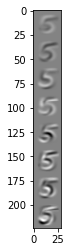

In [55]:
pca = RandomizedPCA(n_components=8, whiten=True)
mnist_5 = mnist_x_train[mnist_y_train==5]

X_transformed = pca.fit_transform(mnist_5.reshape(mnist_5.shape[0], -1))
plt.imshow(pca.components_.reshape((8 * 28, 28)), cmap="gray")

In [56]:
from sklearn.neighbors import KNeighborsClassifier
clas = KNeighborsClassifier()
# clas = KNeighborsClassifier()
print sm_train.shape
print sm_y_train.shape
clas.fit(sm_train, sm_y_train)

(500, 784)
(500,)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [ ]:
print sm_train.shape
pred_train = clas.predict(sm_train)
print pred_train
print 'train: ', accuracy_score(sm_y_train, pred_train)

pred_test = clas.predict(sm_test)
print 'test: ', accuracy_score(sm_y_test, pred_test)